# Chapter 2. Missing Data

### 1. Setup

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('data/input/train.csv', index_col='Id')
X_test_full = pd.read_csv('data/input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])
X_test = X_test_full.select_dtypes(exclude=['object'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [4]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,20,90.0,11694,9,5,2007,2007,452.0,48,0,...,774,0,108,0,0,260,0,0,7,2007
871,20,60.0,6600,5,5,1962,1962,0.0,0,0,...,308,0,0,0,0,0,0,0,8,2009
93,30,80.0,13360,5,7,1921,2006,0.0,713,0,...,432,0,0,44,0,0,0,0,8,2009
818,20,NaN,13265,8,5,2002,2002,148.0,1218,0,...,857,150,59,0,0,0,0,0,7,2008
303,20,118.0,13704,7,5,2001,2002,150.0,0,0,...,843,468,81,0,0,0,0,0,1,2006


In [154]:
X_valid.shape

(292, 60)

### 2. Preliminary investigation

In [7]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1168, 36)
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


In [13]:
# Fill in the line below: How many rows are in the training data?
num_rows = X_train.shape[0]
print(f'Number of rows in the training data is: {num_rows}')

# Fill in the line below: How many columns in the training data
# have missing values?
num_cols_with_missing = len(missing_val_count_by_column[missing_val_count_by_column > 0])
print(f'Number of columns containing missing values in the training data is: {num_cols_with_missing}')

# Fill in the line below: How many missing entries are contained in 
# all of the training data?
tot_missing = sum(missing_val_count_by_column)
print(f'The total number of missing entries in all of the training data is: {tot_missing}')

Number of rows in the training data is: 1168
Number of columns containing missing values in the training data is: 3
The total number of missing entries in all of the training data is: 276


Considering your answers above, what do you think is likely the best approach to dealing with the missing values?

    >> Imputation

To compare different approaches to dealing with missing values, you'll use the same score_dataset() function from the tutorial. This function reports the mean absolute error (MAE) from a random forest model.

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=200, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### 3. Drop columns with missing values

In this step, you'll preprocess the data in X_train and X_valid to remove columns with missing values. Set the preprocessed DataFrames to reduced_X_train and reduced_X_valid, respectively.

In [82]:
# Fill in the line below: get names of columns with missing values
cols_to_drop = missing_val_count_by_column[missing_val_count_by_column > 0].index # Your code here

# Fill in the lines below: drop columns in training and validation data
reduced_X_train = X_train.drop(columns=cols_to_drop, axis=1)
reduced_X_valid = X_valid.drop(columns=cols_to_drop, axis=1)

In [83]:
print("MAE (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE (Drop columns with missing values):
17405.510861872146


### 4. Imputation

Although it's simple, filling in the mean value generally performs quite well (but this varies by dataset). While statisticians have experimented with more complex ways to determine imputed values (such as regression imputation, for instance), the complex strategies typically give no additional benefit once you plug the results into sophisticated machine learning models.

Use the next code cell to impute missing values with the mean value along each column. Set the preprocessed DataFrames to imputed_X_train and imputed_X_valid. Make sure that the column names match those in X_train and X_valid.

In [61]:
from sklearn.impute import SimpleImputer

# Fill in the lines below: imputation
imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))

# Fill in the lines below: imputation removed column names; put them back
# Get the original column names
original_columns = list(X_train.columns)

# Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = original_columns
imputed_X_valid.columns = original_columns


In [62]:
print("MAE (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE (Imputation):
18062.894611872147


Let's try to add columns that will describe if the value was imputed.

In [57]:
from sklearn.impute import SimpleImputer

# Fill in the lines below: imputation
imputer = SimpleImputer(keep_empty_features=True, add_indicator=True)
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))

# Fill in the lines below: imputation removed column names; put them back
# Get the original column names
original_columns = list(X_train.columns)

# Get the imputed columns, including indicator columns
imputed_columns = list(X_train.columns) + list(imputed_X_train.columns[len(X_train.columns):].astype(str))

# Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = imputed_columns
imputed_X_valid.columns = imputed_columns


In [58]:
print("MAE (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE (Imputation):
18148.417180365297


In [69]:
from sklearn.impute import KNNImputer

# Fill in the lines below: imputation
imputer = KNNImputer(keep_empty_features=True)
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))

# Fill in the lines below: imputation removed column names; put them back
# Get the original column names
original_columns = list(X_train.columns)

# Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = original_columns
imputed_X_valid.columns = original_columns

In [70]:
print("MAE (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE (Imputation):
17845.387226027397


This is better, but the simple drop is slightly better. Maybe we can play with the KNNImputer to see if we can make it better.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Fill in the lines below: imputation
#imputer = SimpleImputer(keep_empty_features=True, add_indicator=True)
imputer = IterativeImputer()
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))

# Fill in the lines below: imputation removed column names; put them back
# Get the original column names
original_columns = list(X_train.columns)

# Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = original_columns
imputed_X_valid.columns = original_columns


In [ ]:
print("MAE (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE (Imputation):
17786.50546803653


Strangly, Imputation performed worst than dropping entire columns.

Given that thre are so few missing values in the dataset, we'd expect imputation to perform better than dropping columns entirely. However, we see that dropping columns performs slightly better! While this can probably partially be attributed to noise in the dataset, another potential explanation is that the imputation method is not a great match to this dataset. That is, maybe instead of filling in the mean value, it makes more sense to set every missing value to a value of 0, to fill in the most frequently encountered value, or to use some other method. For instance, consider the GarageYrBlt column (which indicates the year that the garage was built). It's likely that in some cases, a missing value could indicate a house that does not have a garage. Does it make more sense to fill in the median value along each column in this case? Or could we get better results by filling in the minimum value along each column? It's not quite clear what's best in this case, but perhaps we can rule out some options immediately - for instance, setting missing values in this column to 0 is likely to yield horrible results!

### 5. Generating test predictions

In this final step, you'll use any approach of your choosing to deal with missing values. Once you've preprocessed the training and validation features, you'll train and evaluate a random forest model. Then, you'll preprocess the test data before generating predictions that can be submitted to the competition!

After experimenting with imputers, I've found that IteravieImputer yields better results than the simple dropping of columns. I've tried several things (SimpleImputer with various options, KNNImputer), but Iterative was the only to produce lower MAE than the simple drop columns.

In [71]:
# Preprocessed training and validation features
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Fill in the lines below: imputation
#imputer = SimpleImputer(keep_empty_features=True, add_indicator=True)
imputer = IterativeImputer()
final_X_train = pd.DataFrame(imputer.fit_transform(X_train))
final_X_valid = pd.DataFrame(imputer.transform(X_valid))

In [78]:
# Define and fit model
model = RandomForestRegressor(n_estimators=200, random_state=0)
model.fit(final_X_train, y_train)

# Get validation predictions and MAE
preds_valid = model.predict(final_X_valid)
print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid))

MAE (Your approach):
17472.398253424657


I see that we get better results just by changing n_estimators to 200. Let's try to optimize hyperpameters

In [79]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomForestRegressor
model = RandomForestRegressor(random_state=0)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(final_X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model
best_model = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [80]:
# Get validation predictions and MAE
preds_valid = best_model.predict(final_X_valid)
print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid))

MAE (Your approach):
17472.398253424657


In [73]:
# Fill in the line below: preprocess test data
final_X_test = pd.DataFrame(imputer.fit_transform(X_test))

# Fill in the line below: get test predictions
preds_test = model.predict(final_X_test)

In [ ]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
# output.to_csv('submission.csv', index=False)

## Chapter 3. Categorical Variables

There are 3 approaches to treat categorical variables.
    
### 1. Drop Categorical Variables
```python 
    drop_X_train = X_train.select_dtypes(exclude=['object'])
```
### 2. Ordinal Encoding
Ordinal encoding assigns each unique value to a different integer.

```python
    import pandas as pd
    from sklearn.preprocessing import OrdinalEncoder

    # Make copy to avoid changing original data 
    label_X_train = X_train.copy()
    label_X_valid = X_valid.copy()

    # Apply ordinal encoder to each column with categorical data
    ordinal_encoder = OrdinalEncoder()
    label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
    label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])
```
    
### 3. One-hot Encoding

We use the OneHotEncoder class from scikit-learn to get one-hot encodings. There are a number of parameters that can be used to customize its behavior.

We set handle_unknown='ignore' to avoid errors when the validation data contains classes that aren't represented in the training data, and
setting sparse=False ensures that the encoded columns are returned as a numpy array (instead of a sparse matrix).

```python
    from sklearn.preprocessing import OneHotEncoder

    # Apply one-hot encoder to each column with categorical data
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
    OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

    # One-hot encoding removed index; put it back
    OH_cols_train.index = X_train.index
    OH_cols_valid.index = X_valid.index

    # Remove categorical columns (will replace with one-hot encoding)
    num_X_train = X_train.drop(object_cols, axis=1)
    num_X_valid = X_valid.drop(object_cols, axis=1)

    # Add one-hot encoded columns to numerical features
    OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
    OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

    # Ensure all columns have string type
    OH_X_train.columns = OH_X_train.columns.astype(str)
    OH_X_valid.columns = OH_X_valid.columns.astype(str)
```

>In general, one-hot encoding (Approach 3) will typically perform best, and dropping the categorical columns (Approach 1) typically performs worst, but it varies on a case-by-case basis.

### 0. Setup

In [152]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv('data/input/train.csv', index_col='Id') 
X_test = pd.read_csv('data/input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll drop columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [91]:
X_train.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
619,20,RL,11694,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,108,0,0,260,0,0,7,2007,New,Partial
871,20,RL,6600,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,0,8,2009,WD,Normal
93,30,RL,13360,Pave,IR1,HLS,AllPub,Inside,Gtl,Crawfor,...,0,44,0,0,0,0,8,2009,WD,Normal
818,20,RL,13265,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,...,59,0,0,0,0,0,7,2008,WD,Normal
303,20,RL,13704,Pave,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,...,81,0,0,0,0,0,1,2006,WD,Normal


In [97]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 619 to 685
Data columns (total 60 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1168 non-null   int64 
 1   MSZoning       1168 non-null   object
 2   LotArea        1168 non-null   int64 
 3   Street         1168 non-null   object
 4   LotShape       1168 non-null   object
 5   LandContour    1168 non-null   object
 6   Utilities      1168 non-null   object
 7   LotConfig      1168 non-null   object
 8   LandSlope      1168 non-null   object
 9   Neighborhood   1168 non-null   object
 10  Condition1     1168 non-null   object
 11  Condition2     1168 non-null   object
 12  BldgType       1168 non-null   object
 13  HouseStyle     1168 non-null   object
 14  OverallQual    1168 non-null   int64 
 15  OverallCond    1168 non-null   int64 
 16  YearBuilt      1168 non-null   int64 
 17  YearRemodAdd   1168 non-null   int64 
 18  RoofStyle      1168 non-null   o

In [153]:
X_valid.shape

(292, 60)

In [102]:
X_train.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 619 to 685
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1168 non-null   object
 1   Street         1168 non-null   object
 2   LotShape       1168 non-null   object
 3   LandContour    1168 non-null   object
 4   Utilities      1168 non-null   object
 5   LotConfig      1168 non-null   object
 6   LandSlope      1168 non-null   object
 7   Neighborhood   1168 non-null   object
 8   Condition1     1168 non-null   object
 9   Condition2     1168 non-null   object
 10  BldgType       1168 non-null   object
 11  HouseStyle     1168 non-null   object
 12  RoofStyle      1168 non-null   object
 13  RoofMatl       1168 non-null   object
 14  Exterior1st    1168 non-null   object
 15  Exterior2nd    1168 non-null   object
 16  ExterQual      1168 non-null   object
 17  ExterCond      1168 non-null   object
 18  Foundation     1168 non-null   o

### 1. Drop categorical columns

In [87]:
# Fill in the lines below: drop columns in training and validation data
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

In [89]:
print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
17405.510861872146


In [155]:
print("Unique values in 'Condition2' column in training data:", X_train['Condition2'].unique())
print("\nUnique values in 'Condition2' column in validation data:", X_valid['Condition2'].unique())

Unique values in 'Condition2' column in training data: ['Norm' 'PosA' 'Feedr' 'PosN' 'Artery' 'RRAe']

Unique values in 'Condition2' column in validation data: ['Norm' 'RRAn' 'RRNn' 'Artery' 'Feedr' 'PosN']


### 2. Ordinal encoding

Fitting an ordinal encoder to a column in the training data creates a corresponding integer-valued label for each unique value that appears in the training data. **In the case that the validation data contains values that don't also appear in the training data, the encoder will throw an error**, because these values won't have an integer assigned to them. Notice that the 'Condition2' column in the validation data contains the values 'RRAn' and 'RRNn', but these don't appear in the training data -- thus, if we try to use an ordinal encoder with scikit-learn, the code will throw an error.

The code cell below will show the problematic columns to a Python list bad_label_cols. Likewise, columns that can be safely ordinal encoded are stored in good_label_cols.

In [103]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded, if unique values in each column in X_valid are also present in the columns in X_valid
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Condition2', 'Functional', 'RoofMatl']


In [104]:
from sklearn.preprocessing import OrdinalEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply ordinal encoder
ordinal_encoder = OrdinalEncoder()
label_X_train[good_label_cols] = ordinal_encoder.fit_transform(X_train[good_label_cols])
label_X_valid[good_label_cols] = ordinal_encoder.transform(X_valid[good_label_cols])


In [105]:
print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
16814.482208904108


In [107]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('KitchenQual', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

The output above shows, for each column with categorical data, the number of unique values in the column.  For instance, the `'Street'` column in the training data has two unique values: `'Grvl'` and `'Pave'`, corresponding to a gravel road and a paved road, respectively.

## 3. Investigating Cardinality

We refer to the number of unique entries of a categorical variable as the **cardinality** of that categorical variable.  For instance, the `'Street'` variable has cardinality 2.

In [138]:
# Fill in the line below: How many categorical variables in the training data
# have cardinality greater than 10?
high_cardinality_numcols = len([a for a in object_nunique if a > 10])
print(high_cardinality_numcols)
# Fill in the line below: How many columns are needed to one-hot encode the 
# 'Neighborhood' variable in the training data?
num_cols_neighborhood = X_train['Neighborhood'].nunique()
print(num_cols_neighborhood)

3
25


For large datasets with many rows, one-hot encoding can greatly expand the size of the dataset. For this reason, we typically will only one-hot encode columns with relatively low cardinality.

In [139]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior2nd', 'Exterior1st', 'Neighborhood']


### 4. One-hot encoding

We are going to encode only low_cardinality columuns.

In [147]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(high_cardinality_cols+low_cardinality_cols, axis=1)
num_X_valid = X_valid.drop(high_cardinality_cols+low_cardinality_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)


In [148]:
print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
17184.68566210046


In [149]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply ordinal encoder
ordinal_encoder = OrdinalEncoder()
label_X_train[good_label_cols] = ordinal_encoder.fit_transform(X_train[good_label_cols])
label_X_valid[good_label_cols] = ordinal_encoder.transform(X_valid[good_label_cols])

model = RandomForestRegressor(n_estimators=200, random_state=0)    
model.fit(label_X_train, y_train)

# Get validation predictions and MAE
preds_valid = model.predict(label_X_valid)

print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid))

# Save test predictions to file
output = pd.DataFrame({'Id': label_X_valid.index,
                       'SalePrice': preds_valid})

MAE (Your approach):
16814.482208904108


In [151]:
output.shape

(292, 2)

## Chapter 4. Pipelines

### Introduction
Pipelines are a simple way to keep your data preprocessing and modeling code organized. Specifically, a pipeline bundles preprocessing and modeling steps so you can use the whole bundle as if it were a single step.

Many data scientists hack together models without pipelines, but pipelines have some important benefits. Those include:

1. **Cleaner Code**: Accounting for data at each step of preprocessing can get messy. With a pipeline, you won't need to manually keep track of your training and validation data at each step.
2. **Fewer Bugs**: There are fewer opportunities to misapply a step or forget a preprocessing step.
3. **Easier to Productionize**: It can be surprisingly hard to transition a model from a prototype to something deployable at scale. We won't go into the many related concerns here, but pipelines can help.
4. **More Options for Model Validation**: You will see an example in the next tutorial, which covers cross-validation.

In [156]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('data/input/train.csv', index_col='Id')
X_test_full = pd.read_csv('data/input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [157]:
X_train.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,774,0,108,0,0,260,0,0,7,2007
871,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,...,308,0,0,0,0,0,0,0,8,2009
93,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,...,432,0,0,44,0,0,0,0,8,2009
818,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,...,857,150,59,0,0,0,0,0,7,2008
303,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,843,468,81,0,0,0,0,0,1,2006


In [158]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')  # this will fill-in missing values with 0, as fill_value is not defined

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17614.81993150685


### Step 1: Improve the performance
*Part A*

Now, it's your turn! In the code cell below, define your own preprocessing steps and random forest model. Fill in values for the following variables:

- numerical_transformer
- categorical_transformer
- model

To pass this step, you need to have defined a pipeline in Part A that achieves lower MAE than the code above. You're encouraged to take your time here and try out many different approaches, to see how low you can get the MAE! 

In [ ]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy="constant", add_indicator=True) # Your code here

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
]) # Your code here

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0) # Your code here


*Part B*

In [ ]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

*Part C*

Generate test predictions

In [ ]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test) # Your code here

# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

## Chapter 5. Cross-Validation

### Introduction

In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.

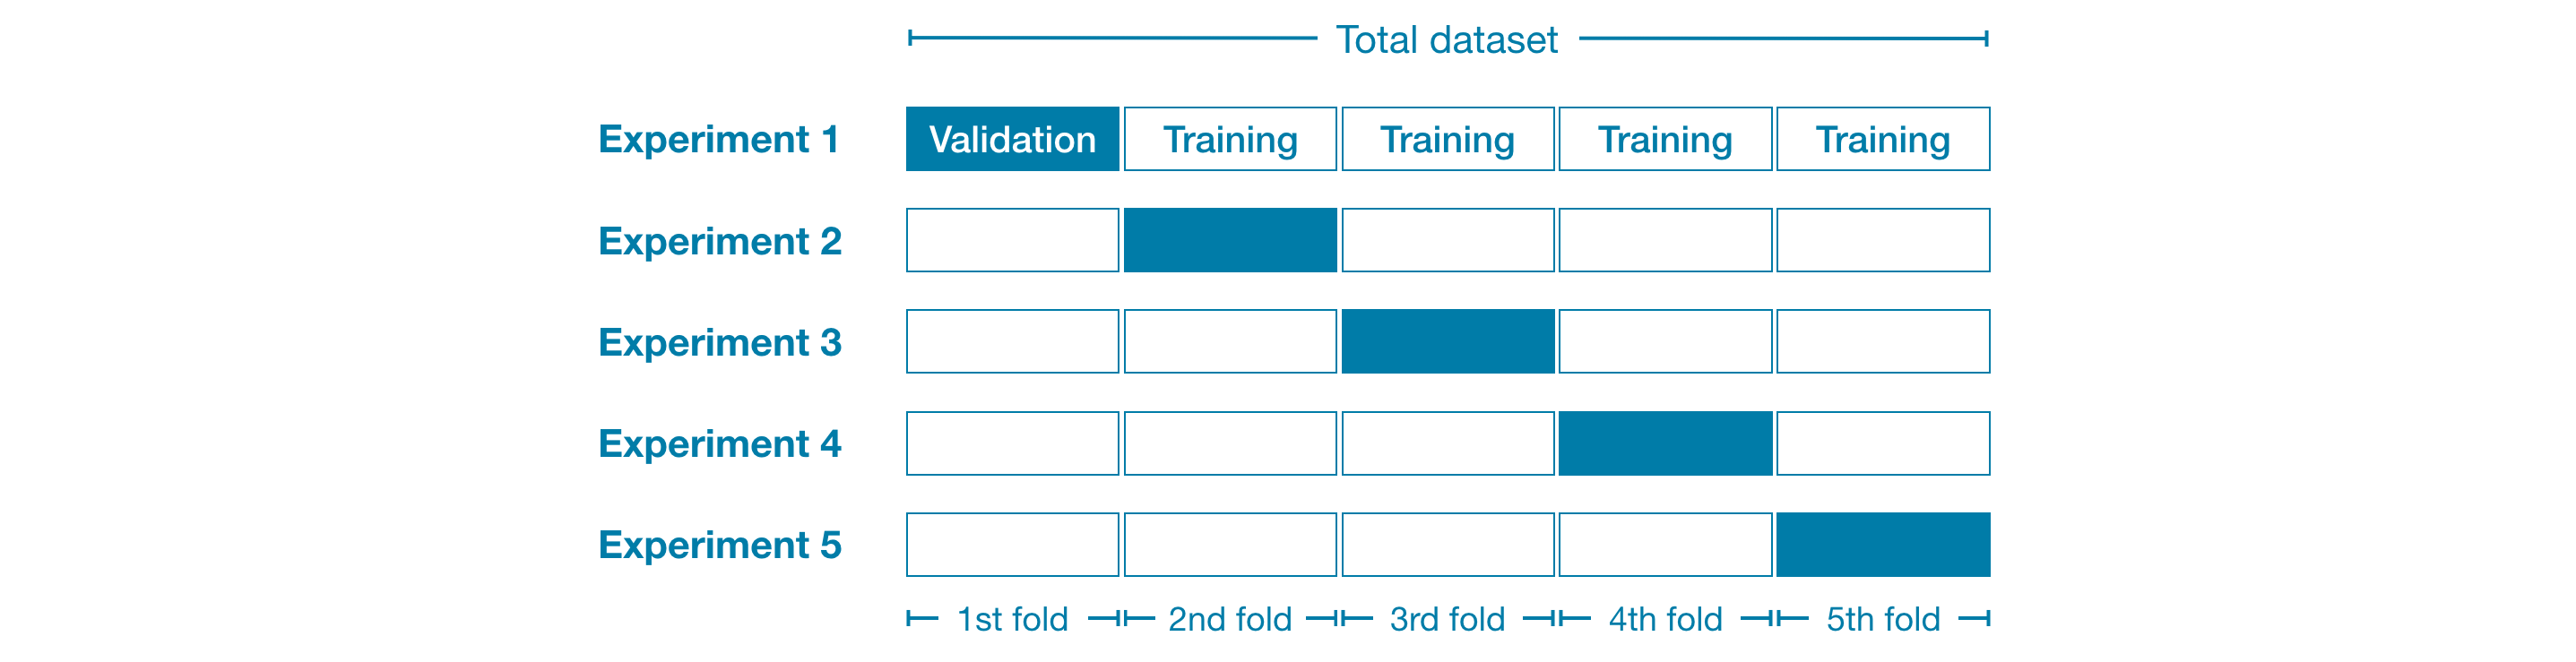

### When should you use cross-validation?¶

Cross-validation gives a more accurate measure of model quality, which is especially important if you are making a lot of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold).

So, given these tradeoffs, when should you use each approach?

* For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.
* For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.

In [161]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
train_data = pd.read_csv('data/input/train.csv', index_col='Id')
test_data = pd.read_csv('data/input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train_data.SalePrice              
train_data.drop(['SalePrice'], axis=1, inplace=True)

# Select numeric columns only
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()

In [162]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


the pipeline below will use SimpleImputer() to replace missing values in the data, before using RandomForestRegressor() to train a random forest model to make predictions. We set the number of trees in the random forest model with the n_estimators parameter, and setting random_state ensures reproducibility.

In [163]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators=50, random_state=0))
])

The code below uses the cross_val_score() function to obtain the mean absolute error (MAE), averaged across five different folds. Recall we set the number of folds with the cv parameter.

In [164]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("Average MAE score:", scores.mean())

Average MAE score: 18276.410356164386
